# Image captioning with visual attention

Given an image like the example below, your goal is to generate a
caption such as "a surfer riding on a wave".

<table style="text-align: center;">
<tr>
  <td>
   <img src="https://tensorflow.org/images/surf.jpg"/>
  </td>
</tr>
<tr>
  <th>A man surfing, from <a href=https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg>wikimedia</a></th>
</tr>
</table>

The model architecture used here is inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), but has been updated to use a 2-layer Transformer-decoder. To get the most out of this tutorial you should have some experience with [text generation](https://www.tensorflow.org/text/tutorials/text_generation),  [seq2seq models & attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention), or [transformers](https://www.tensorflow.org/text/tutorials/transformer).

The model architecture built in this tutorial is shown below. Features are extracted from the image, and passed to the cross-attention layers of the Transformer-decoder.

<table>
<tr>
  <th>The model architecture</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"/>
  </td>
</tr>
</table>

The transformer decoder is mainly built from attention layers. It uses self-attention to process the sequence being generated, and it uses cross-attention to attend to the image.

By inspecting the attention weights of the cross attention layers you will see what parts of the image the model is looking at as it generates words.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

This notebook is an end-to-end example. When you run the notebook, it downloads a dataset, extracts and caches the image features, and trains a decoder model. It then uses the model to generate captions on new images.

## Setup

In [1]:
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm
from helpers import *
import tensorflow as tf
import tensorflow_text as text
import tensorflow_datasets as tfds

2025-01-19 10:19:03.908134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737299943.946259 1154368 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737299943.956190 1154368 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 10:19:03.980704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# List all devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Alternatively, use this for a more straightforward GPU-specific check
print("Available GPU devices: ", tf.config.list_physical_devices('GPU'))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5336588016312357427
xla_global_id: -1
]
Available GPU devices:  []


2025-01-19 10:19:07.312862: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-01-19 10:19:07.312923: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: ml
2025-01-19 10:19:07.312936: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: ml
2025-01-19 10:19:07.313193: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2025-01-19 10:19:07.313263: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2025-01-19 10:19:07.313277: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


## [Optional] Data handling

This section downloads a captions dataset and prepares it for training. It tokenizes the input text, and caches the results of running all the images through a pretrained feature-extractor model. It's not critical to understand everything in this section.


### Choose a dataset

This tutorial is set up to give a choice of datasets. Either [Flickr8k](https://www.ijcai.org/Proceedings/15/Papers/593.pdf) or a small slice of the [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) dataset. These two are downloaded and converted from scratch, but it wouldn't be hard to convert the tutorial to use the caption datasets available in [TensorFlow Datasets](https://www.tensorflow.org/datasets): [Coco Captions](https://www.tensorflow.org/datasets/catalog/coco_captions) and the full [Conceptual Captions](https://www.tensorflow.org/datasets/community_catalog/huggingface/conceptual_captions).


#### Download the dataset

The Flickr8k is a good choice because it contains 5-captions per image, more data for a smaller download.

In [3]:
choose = 'coco'

if choose == 'flickr8k':
  train_raw, test_raw = flickr8k()
else:
  train_raw, test_raw = conceptual_captions(num_train=10000, num_val=5000)

100%|██████████| 5000/5000 [00:10<00:00, 492.31it/s]


The loaders for both datasets above return `tf.data.Dataset`s containing `(image_path, captions)` pairs. The Flickr8k dataset contains 5 captions per image, while Conceptual Captions has 1:

In [4]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(1,), dtype=tf.string, name=None))

In [5]:
test_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(1,), dtype=tf.string, name=None))

In [6]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'conceptual_captions/train/fa108ae1f21b05518409b760bfec035dbfb3a194.jpeg', shape=(), dtype=string)
tf.Tensor([b'a very typical bus station'], shape=(1,), dtype=string)


2025-01-19 10:19:56.484580: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Image feature extractor

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  


In [7]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

The model returns a feature map for each image in the input batch:

In [8]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


### Setup the text tokenizer/vectorizer

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [9]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [10]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

2025-01-19 10:19:58.926851: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'the', 'a', 'of', 'in', 'on', 'and']

In [12]:
sample = tokenizer([['a cat in a hat'], ['a robot dog']])
sample

<tf.RaggedTensor [[2, 5, 245, 7, 5, 431, 3], [2, 5, 1503, 121, 3]]>

In [13]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [14]:
words = index_to_word(sample)
words.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [15]:
tf.strings.reduce_join(words, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Prepare the datasets

The `train_raw` and `test_raw` datasets contain 1:many `(image, captions)` pairs.

This function will replicate the image so there are 1:1 images to captions:

In [16]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 1)

image_paths: (32,)
captions: (32,)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

You could install the feature extractor in your model and train on the datasets like this:

In [44]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int32, name=None))

In [45]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int32, name=None))

### [Optional] Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions `save_dataset` and `load_dataset`:

In [42]:
# save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
# save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

## Data ready for training

After those preprocessing steps, here are the datasets:

In [43]:
# train_ds = load_dataset('train_cache')
# test_ds = load_dataset('test_cache')

In [46]:
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int32, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [22]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 21)
(32, 21)


The input tokens and the labels are the same, just shifted by 1 step:

In [23]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   2  120  580  354   41  571  204 1793 2270  794   60 4145    7  209
 3843    0    0    0    0    0    0]
[ 120  580  354   41  571  204 1793 2270  794   60 4145    7  209 3843
    3    0    0    0    0    0    0]


## A Transformer decoder model

This model assumes that the pretrained image encoder is sufficient, and just focuses on building the text decoder. This tutorial uses a 2-layer Transformer-decoder.

The implementations are almost identical to those in the [Transformers tutorial](https://www.tensorflow.org/text/tutorials/transformer). Refer back to it for more details.

<table>
<tr>
  <th>The Transformer encoder and decoder.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts:

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs.

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The `SeqEmbedding` layer defined below:

- It looks up the embedding vector for each token.
- It looks up an embedding vector for each sequence location.
- It adds the two together.
- It uses `mask_zero=True` to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer). Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [24]:
class SeqEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, max_length, depth):
        """
        Initialize the SeqEmbedding layer.
        
        Args:
        vocab_size (int): Size of the vocabulary (number of unique tokens).
        max_length (int): Maximum length of the input sequences.
        depth (int): Dimensionality of the embeddings.
        """
        super(SeqEmbedding, self).__init__()
        # Positional embedding layer, encodes the position of each token in the sequence.
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

        # Token embedding layer, encodes each token in the vocabulary into a dense vector.
        self.token_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size, 
            output_dim=depth, 
            mask_zero=True)  # Allows the layer to ignore zeros in input for padding purposes.

        # Layer to add token and position embeddings together.
        self.add = tf.keras.layers.Add()

    def call(self, seq, training=True):
        """
        The logic for one forward pass of SeqEmbedding.
        
        Args:
        seq (Tensor): Input tensor containing token indices of the sequence.
        
        Returns:
        Tensor: Combined embedding of the input sequence after adding token and position embeddings.
        """
        # Compute token embeddings: transforms token indices into embeddings.
        seq = self.token_embedding(seq)  # (batch, seq, depth)

        # Generate a sequence of position indices and expand dims to match batch size.
        x = tf.range(tf.shape(seq)[1])  # (seq) - Generates a range tensor from 0 to seq length.
        x = x[tf.newaxis, :]  # (1, seq) - Adds a batch dimension to align with seq's batch size.
        x = self.pos_embedding(x)  # (1, seq, depth) - Computes position embeddings.

        # Add the token embeddings and position embeddings.
        return self.add([seq, x])


### Decoder

The decoder is a standard Transformer-decoder, it contains a stack of `DecoderLayers` where each contains three sublayers: a `CausalSelfAttention`, a `CrossAttention`, and a`FeedForward`. The implementations are almost identical to the [Transformer tutorial](https://www.tensorflow.org/text/tutorials/transformer), refer to it for more details.

The `CausalSelfAttention` layer is below:

In [25]:
class CausalSelfAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        """
        Initializes the CausalSelfAttention layer which is a component of Transformer architectures
        that uses masked self-attention to prevent positions from attending to subsequent positions.

        Args:
        **kwargs: Arguments for the MultiHeadAttention layer, such as the number of attention heads, 
                  key/value/query dimensions, etc.
        """
        super(CausalSelfAttention, self).__init__()
        # Multi-head attention layer with the specified properties passed via kwargs.
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)

        # Addition layer to combine the input and the attention output; it also ensures that any mask
        # information present in the input is carried through to the output.
        self.add = tf.keras.layers.Add()

        # Layer normalization to stabilize the learning process by normalizing the input layer by mean
        # and variance.
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x, training=True):
        """
        The logic for one forward pass of the CausalSelfAttention layer.

        Args:
        x (Tensor): The input tensor to the attention layer.

        Returns:
        Tensor: The output tensor after applying causal self-attention and normalization.
        """
        # Apply multi-head attention with a causal mask to ensure that the prediction for a specific
        # position only depends on the known outputs at previous positions.
        attn = self.mha(query=x, value=x, use_causal_mask=True)

        # Combine the original input tensor with the attention output tensor. This step is crucial for
        # implementing the Transformer's characteristic residual connections, which help in training
        # deeper models by allowing gradients to flow through the network more effectively.
        x = self.add([x, attn])

        # Normalize the output of the attention and residual addition to ensure that the output
        # distribution has a mean of zero and a standard deviation of one, which helps in stabilizing
        # the training process.
        return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [26]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units = 256, **kwargs):
        """
        Initializes the CrossAttention layer which facilitates focusing on different positions of one sequence
        based on another sequence. Commonly used in models that require context from a different modality or sequence.

        Args:
        **kwargs: Configuration arguments for the MultiHeadAttention layer, such as number of heads, 
                  dimensionality of the model, etc.
        """
        super(CrossAttention, self).__init__()
        # MultiHeadAttention to compute attention from one sequence to another.
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)

        # Add layer to facilitate the residual connection, aiding in gradient flow during deep network training.
        self.add = tf.keras.layers.Add()

        # LayerNormalization to normalize the outputs of the layer for stable training dynamics.
        self.layernorm = tf.keras.layers.LayerNormalization()

        self.dense_image = tf.keras.layers.Dense(units, activation='relu')  # For image features


    def call(self, x, y, training=True, **kwargs):
        """
        Perform a forward pass of the CrossAttention layer using two sequences: 'x' and 'y'.

        Args:
        x (Tensor): The query tensor; typically the sequence where you want to apply the learned attention.
        y (Tensor): The value and key tensor; typically the sequence to be attended to.
        **kwargs: Additional keyword arguments to pass to the MultiHeadAttention layer.

        Returns:
        Tensor: The output tensor after applying cross-attention followed by layer normalization.
        """
        
        # Transform image features to have the same dimension as text embeddings
        y = self.dense_image(y)

        # Compute attention where 'x' queries 'y'. This allows 'x' to focus on relevant parts of 'y'.
        attn, attention_scores = self.mha(query=x, value=y, return_attention_scores=True)

        # Store the attention scores for visualization or inspection purposes to understand
        # how 'x' is attending to 'y'.
        self.last_attention_scores = attention_scores

        # Add the original input 'x' to the attention output to maintain the flow of information
        # through the network and prevent the vanishing gradient problem.
        x = self.add([x, attn])

        # Normalize the summed output to aid in training stability and efficiency.
        return self.layernorm(x)


The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [27]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, units, dropout_rate=0.1):
        """
        Initializes the FeedForward layer with a two-layer neural network and dropout for regularization.

        Args:
        units (int): Number of neurons in the hidden layer and the output size of the final Dense layer.
        dropout_rate (float): Fraction of the input units to drop as a form of regularization.

        """
        super(FeedForward, self).__init__()
        # Sequential model consisting of two Dense layers and a Dropout layer.
        # The first Dense layer doubles the dimensionality, followed by ReLU activation for non-linearity.
        # The second Dense layer brings the dimensionality back to the original size.
        # Dropout is applied for regularization to prevent overfitting.
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(units=2*units, activation='relu'),  # First layer with ReLU activation
            tf.keras.layers.Dense(units=units),  # Second layer to project the dimensions back
            tf.keras.layers.Dropout(rate=dropout_rate),  # Dropout to reduce overfitting
        ])

        # Layer normalization to stabilize the learning process by normalizing the layer's output.
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x, training = True):
        """
        Forward pass for the FeedForward layer. Computes the sequential operations and applies a residual connection.

        Args:
        x (Tensor): Input tensor to the feed-forward network.

        Returns:
        Tensor: The output tensor after applying the dense layers, dropout, and layer normalization.
        """
        # Apply the sequential model to the input tensor and add the result to the original input tensor
        # (residual connection). This helps the gradient to flow through the network directly during backpropagation.
        x = x + self.seq(x)

        # Normalize the result to ensure stable training dynamics and faster convergence.
        return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [28]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=1, dropout_rate=0.1):
        """
        Initializes a Decoder Layer that combines self-attention, cross-attention, and a feed-forward network.
        
        Args:
        units (int): Number of units in each attention mechanism and the feed-forward network.
        num_heads (int): Number of attention heads in both self and cross-attention layers.
        dropout_rate (float): Dropout rate to be used in attention mechanisms and the feed-forward network.
        """
        super(DecoderLayer, self).__init__()

        # Self-attention layer with causal masking to ensure that predictions for a position
        # can depend only on the known outputs at positions before it in the output sequence.
        self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                                  key_dim=units,
                                                  dropout=dropout_rate)

        # Cross-attention layer where the queries come from the previous self-attention layer's output
        # and the keys and values come from the output of the encoder stack.
        self.cross_attention = CrossAttention(num_heads=num_heads,
                                              units = units,
                                              key_dim=units,
                                              dropout=dropout_rate)

        # Feed-forward network that transforms the feature space of the output after attention mechanisms.
        self.ff = FeedForward(units=units, dropout_rate=dropout_rate)

    def call(self, inputs, training=True):
        """
        Forward pass for the DecoderLayer.
        
        Args:
        inputs (tuple): Tuple of tensors (in_seq, out_seq) where 'in_seq' is from the encoder output and
                        'out_seq' is the previous layer's output or the target sequence during training.
        training (bool): Boolean flag indicating whether the layer should behave in training mode or inference mode.

        Returns:
        Tensor: The output of the decoder layer after processing through self-attention,
                cross-attention, and the feed-forward network.
        """
        in_seq, out_seq = inputs

        # Apply self-attention to the output sequence. Here, causal masking prevents the layer from
        # using future tokens in the sequence to generate the current token outputs.
        out_seq = self.self_attention(out_seq)

        # Apply cross-attention, where the layer can attend to the encoder's output sequence (in_seq)
        # based on the information in the current sequence (out_seq).
        out_seq = self.cross_attention(out_seq, in_seq)

        # Store the last attention scores from the cross-attention layer, which might be useful
        # for visualization or analysis to understand how the decoder attends to the encoder's outputs.
        self.last_attention_scores = self.cross_attention.last_attention_scores

        # Apply the feed-forward network to the output of the attention layers.
        out_seq = self.ff(out_seq)

        return out_seq


### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`,
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well.

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [29]:
class TokenOutput(tf.keras.layers.Layer):
    def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
        """
        Initializes the TokenOutput layer with a dense layer and handles token frequency biasing.

        Args:
        tokenizer (Tokenizer): A tokenizer instance that converts text to token indices and provides vocabulary size.
        banned_tokens (tuple of str): Tokens to be explicitly banned from prediction outputs.
        **kwargs: Additional keyword arguments passed to the Dense layer constructor.
        """
        super(TokenOutput, self).__init__()

        # Dense layer that outputs logits for each token in the tokenizer's vocabulary.
        self.dense = tf.keras.layers.Dense(units=tokenizer.vocabulary_size(), **kwargs)
        self.tokenizer = tokenizer
        self.banned_tokens = banned_tokens

        # Bias to be added to the logits; initialized as None and set during the `adapt` method.
        self.bias = None

    def adapt(self, ds):
        """
        Adapt the layer based on token frequencies in the dataset to adjust biases for token prediction.

        Args:
        ds (tf.data.Dataset): Dataset containing sequences of token indices.
        """
        counts = collections.Counter()
        vocab_dict = {name: id for id, name in enumerate(self.tokenizer.get_vocabulary())}

        # Count the frequency of each token in the dataset.
        for tokens in tqdm.tqdm(ds):
            counts.update(tokens.numpy().flatten())

        counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
        counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

        # Calculate the probabilities and log probabilities of tokens.
        total = counts_arr.sum()
        p = counts_arr / total
        p[counts_arr == 0] = 1.0
        log_p = np.log(p)  # Take log to compute log probabilities, avoiding log(0) by setting zero probabilities to 1 temporarily.

        entropy = -(log_p * p).sum()  # Calculate the entropy to assess the distribution of token frequencies.

        # Display the uniform and marginal entropy.
        print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
        print(f"Marginal entropy: {entropy:0.2f}")

        # Set biases for logits based on the log probabilities, effectively banning certain tokens by setting a very high negative bias.
        self.bias = log_p
        for token in self.banned_tokens:
            self.bias[vocab_dict[token]] = -1e9  # Effectively removes banned tokens from consideration.

    def call(self, x):
        """
        Forward pass to compute logits and add bias.

        Args:
        x (Tensor): Input tensor to the dense layer.

        Returns:
        Tensor: Output logits adjusted by token frequency bias.
        """
        x = self.dense(x)  # Compute logits for each token.
        # Add bias to logits. The bias adjustment helps in shaping the probability distribution based on observed token frequencies.
        return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [30]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 214/214 [00:01<00:00, 183.30it/s]

Uniform entropy: 8.52
Marginal entropy: 3.44


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [49]:
class Captioner(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        """
        Dynamically adds a new method to the Captioner class. This can be used to extend
        the class with custom functionalities during runtime, such as adding new processing
        methods or adaptations without altering the initial class definition.

        Args:
            fun (function): A function to add as a method to the class.

        Returns:
            function: The same function, enabling this method to be used as a decorator.
        """
        setattr(cls, fun.__name__, fun)
        return fun
    
    def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
                 units=256, max_length=50, num_heads=1, dropout_rate=0.1):
        super(Captioner, self).__init__()
        self.feature_extractor = feature_extractor
        self.feature_extractor.trainable = False  # Ensure the feature extractor is not trainable

        self.tokenizer = tokenizer

        self.word_to_index = tf.keras.layers.StringLookup(
            mask_token="",
            vocabulary=tokenizer.get_vocabulary())

        self.index_to_word = tf.keras.layers.StringLookup(
            mask_token="",
            vocabulary=tokenizer.get_vocabulary(),
            invert=True)

        self.seq_embedding = SeqEmbedding(
            vocab_size=tokenizer.vocabulary_size(),
            depth=units,
            max_length=max_length)

        self.decoder_layers = [
            DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
            for n in range(num_layers)]

        self.output_layer = output_layer

        # Explicitly build the model to initialize all weights
        self.build((None, 224, 224, 3))  # Assuming IMAGE_SHAPE is (224, 224, 3)

    def call(self, inputs, training=False):
        images, texts = inputs
        images = self.feature_extractor(images)  # Extract features
        images = einops.rearrange(images, 'b h w c -> b (h w) c')  # Flatten the feature map

        # Prepare text input
        if texts.dtype == tf.string:
            texts = self.tokenizer(texts)
        texts = self.seq_embedding(texts)

        # Process through decoder layers
        for decoder_layer in self.decoder_layers:
            texts = decoder_layer((images, texts))

        # Final output layer
        return self.output_layer(texts)

    def simple_gen(self, image, temperature=1):
        """
        Generates a caption for a given image using a greedy or stochastic approach based on the temperature parameter.

        Args:
            image (tf.Tensor): The image tensor for which to generate the caption. Expected shape is that required by the
                            feature_extractor, typically (height, width, channels).
            temperature (float): A parameter controlling the randomness of the predictions. A temperature of 0 leads to
                                greedy decoding (picking the most likely next word at each step). Higher temperatures
                                result in more random outputs, increasing diversity.

        Returns:
            str: The generated caption as a string.
        """
        # Convert the start token to its corresponding index in the vocabulary to initialize the sequence.
        initial = self.word_to_index([['[START]']])  # (batch, sequence)

        img_features = image[tf.newaxis, ...] # Add batch dimension

        # Initialize the tokens with the start token.
        tokens = initial  # (batch, sequence)

        # Generate tokens for the caption up to a maximum length of 50 tokens.
        for n in range(50):
            # Predict the next token's logits given the image features and current tokens.
            preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
            preds = preds[:, -1, :]  # (batch, vocab) - Consider only the last token's logits for next word prediction.

            # Determine the next token based on the temperature.
            if temperature == 0:
                # If temperature is zero, use greedy decoding: choose the highest probability token.
                next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
            else:
                # If temperature is non-zero, sample from the probability distribution after adjusting by temperature.
                next = tf.random.categorical(preds / temperature, num_samples=1)  # (batch, 1)

            # Append the predicted next token to the sequence.
            tokens = tf.concat([tokens, next], axis=1)  # (batch, sequence)

            # Check if the next token is the end token. If so, stop the generation.
            if next[0] == self.word_to_index('[END]'):
                break

        # Convert the sequence of token indices back to words, skipping the start and end tokens.
        words = self.index_to_word(tokens[0, 1:-1])
        # Join the list of words into a single string to form the final caption.
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        return result.numpy().decode()  # Convert the result tensor to a Python string and decode to UTF-8 if necessary.

    def build(self, input_shape):
        # Building the model to ensure all layers are initialized correctly
        super(Captioner, self).build(input_shape)
        print("Model built with input shape:", input_shape)

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.


In [71]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=5, num_heads=1)

Model built with input shape: (None, 224, 224, 3)


### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [37]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

To caption an image with this model:

- Extract the `img_features`
- Initialize the list of output tokens with a `[START]` token.
- Pass `img_features` and `tokens` into the model.
  - It returns a list of logits.
  - Choose the next token based on those logits.  
  - Add it to the list of tokens, and continue the loop.
  - If it generates an `'[END]'` token, break out of the loop.

So add a "simple" method to do just that:

In [34]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

/home/ramin/Documents/GEN-AI/env_gpu/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


graduates milan youngest astra travels milan repairs travels directed rent vibrant graduates rap worlds virtual youngest exploration winery ultimate vocal worlds pilot exploration rap alternative virtual rent virtual defeating virtual youngest skate rap piled wires astra rap network rent festivals rap visits festivals youngest subway rent silly virtual rap
wreathed repairs victims injury expansive exploration competes touchline wintry piled silly visits icy wines subway compared sidelines wallflower worlds winery bakery vocal preschool taping hoping travels km publicity repairs pilot provided attacked sorting pilot 1st whistle situations rivers pears compared travels provided vocalist winery worlds repairs wonderfully windswept victims
anticipated wetlands lays vocal network attacked enters checking whistle weird treasure 7 ranked memory pilot compact visuals macaques rental sidelines pilot refresh 2000 leaves attacked worst astra guitarist rivers skate whistle touchline whistle zodiac

In [83]:
(image, x), y = next(iter(train_ds)) 
image = image[0]

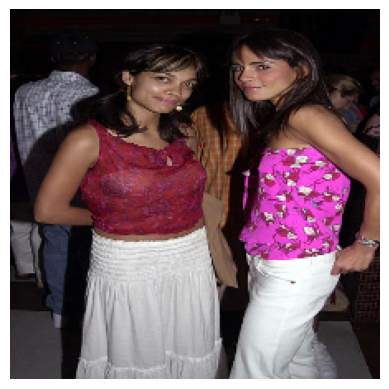

In [84]:
# Assuming `image_tensor` is your image tensor variable
if tf.reduce_max(image) > 1.0:
    image_tensor = image / 255.0

plt.imshow(image_tensor)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

The temperature parameter allows you to interpolate between 3 modes:

1. Greedy decoding (`temperature=0.0`) - Chooses the most likely next token at each step.
2. Random sampling according to the logits (`temperature=1.0`).
3. Uniform random sampling (`temperature >> 1.0`).

Since the model is untrained, and it used the frequency-based initialization, the "greedy" output (first) usually only contains the most common tokens: `['a', '.', '[END]']`.

## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [39]:
def masked_loss(labels, preds):
    """
    Computes the loss by masking out certain entries based on the label values.
    
    Args:
    labels (tf.Tensor): Ground truth labels, typically integers where `0` is used for padding.
    preds (tf.Tensor): Raw model predictions (logits) before applying softmax.
    
    Returns:
    tf.Tensor: The mean loss after masking irrelevant entries.
    """
    # Ensure labels are in the correct data type.
    labels = tf.cast(labels, tf.int64)

    # Compute the cross-entropy loss for each class prediction.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=preds)
    
    # Create a mask that ignores both padding and any extremely high loss values that might indicate anomalies.
    mask = (labels != 0) & (loss < 1e8)
    mask = tf.cast(mask, loss.dtype)
    
    # Apply the mask to the loss.
    loss = loss * mask

    # Compute the mean loss where only the masked entries contribute to the final result.
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss


def masked_acc(labels, preds):
    """
    Calculates the accuracy of predictions, masked to ignore padding or other specified tokens.

    Args:
    labels (tf.Tensor): Ground truth labels.
    preds (tf.Tensor): The logits from a model (predictions before softmax).
    
    Returns:
    tf.Tensor: The masked accuracy, as a scalar tensor.
    """
    # Create a mask that ignores zero labels.
    mask = tf.cast(labels != 0, tf.float32)
    
    # Convert predictions logits to discrete class predictions.
    preds = tf.argmax(preds, axis=-1)
    labels = tf.cast(labels, tf.int64)
    
    # Determine which predictions match the labels.
    match = tf.cast(preds == labels, mask.dtype)
    
    # Calculate accuracy using the mask.
    acc = tf.reduce_sum(match * mask) / tf.reduce_sum(mask)
    return acc


### Train

Configure and execute the training.

In [72]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`.

With this setup on `Flickr8k` a full pass over the dataset is 900+ batches, but below the reporting-epochs are 100 steps.

In [ ]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=50,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=20)

Plot the loss and accuracy over the training run:

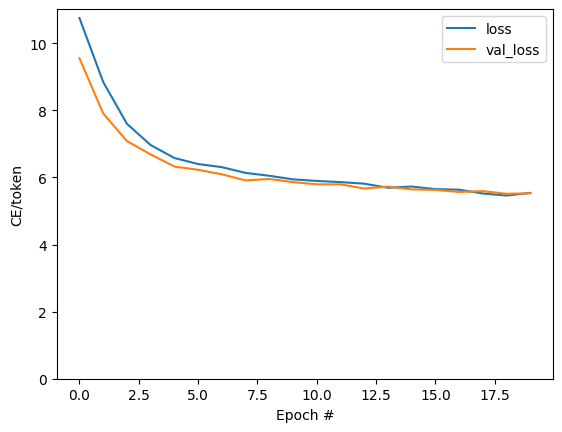

In [54]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

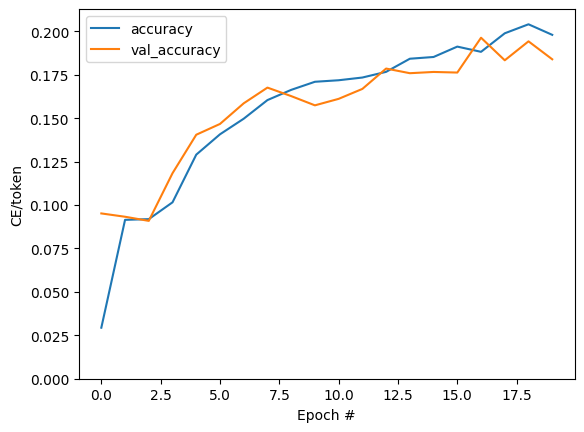

In [55]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

Now, using the trained model,  run that `simple_gen` method on the image:

In [89]:
result = model.simple_gen(image, temperature=0.2)
result

/home/ramin/Documents/GEN-AI/env_gpu/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 1, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


'person and person in the match'

Split the output back into tokens:

In [90]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [91]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 1, 7, 49]),
 TensorShape([1, 1, 7, 49]),
 TensorShape([1, 1, 7, 49]),
 TensorShape([1, 1, 7, 49]),
 TensorShape([1, 1, 7, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`:


In [92]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now you have a single attention map, for each sequence prediction. The values in each map should sum to `1.`

In [93]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([1.0000001 , 1.        , 1.        , 1.        , 1.0000001 ,
       1.        , 0.99999994], dtype=float32)>

So here is where the model was focusing attention while generating each token of the output:

In [94]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

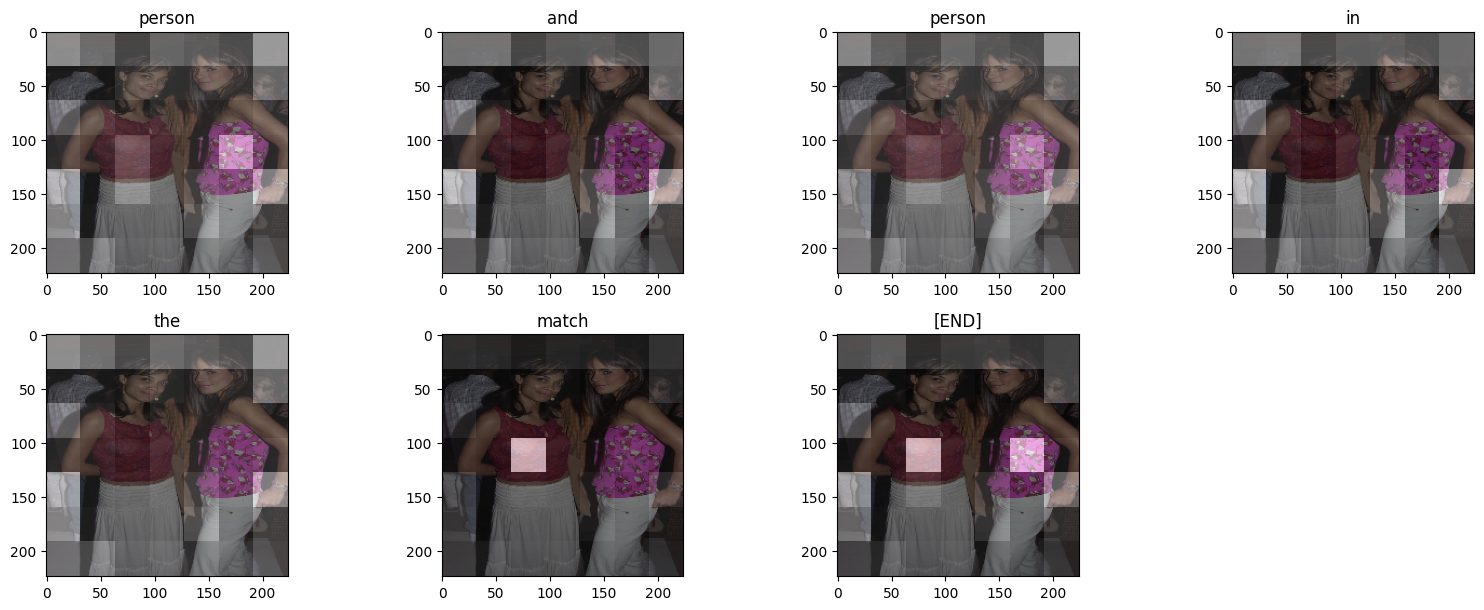

In [95]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Now put that together into a more usable function:

In [96]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


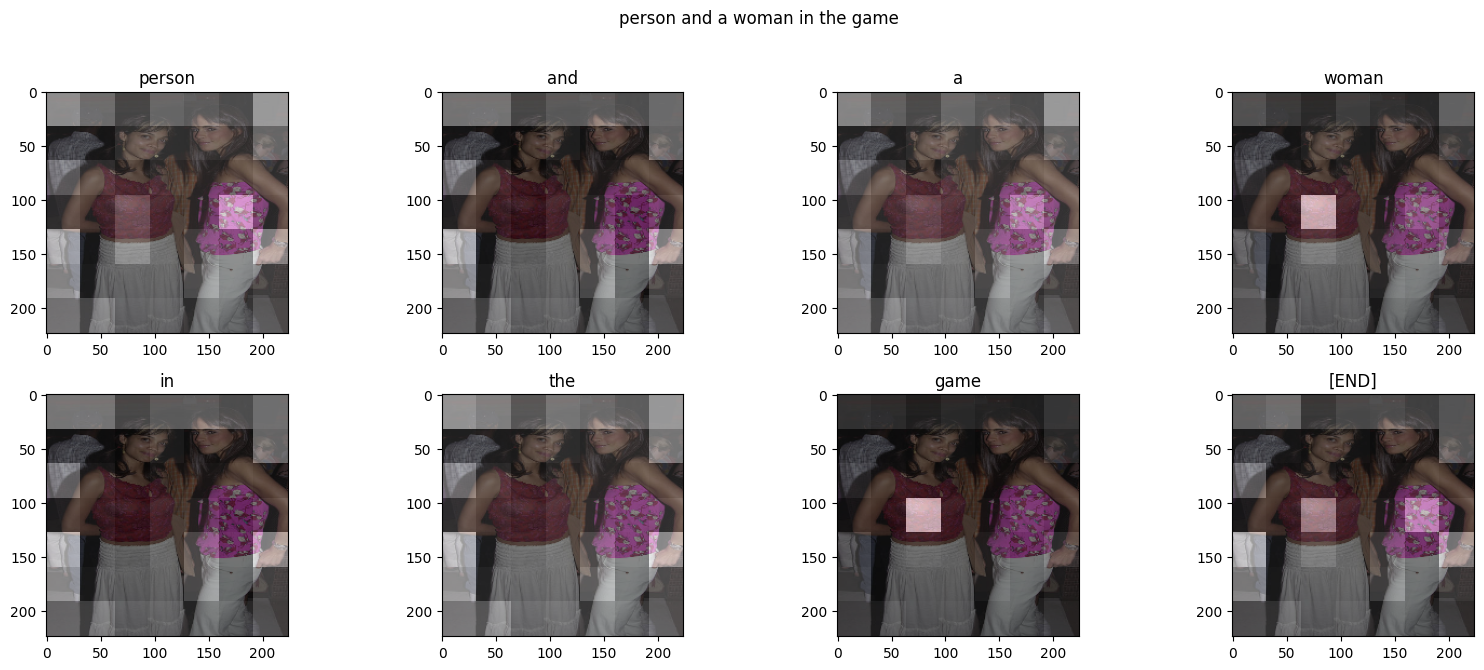

In [97]:
run_and_show_attention(model, image)

## Try it on your own images

For fun, below you're provided a method you can use to caption your own images with the model you've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for strange results!)


In [ ]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)